In [54]:
# tools
import pandas as pd
import numpy as np
from time import time

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# prepare data 
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from deepforest import CascadeForestClassifier

# metrics
from sklearn.metrics import f1_score, accuracy_score

# hyper-param tuning
from sklearn.model_selection import GridSearchCV

## Preparing data

In [68]:
full = pd.read_csv('../data/tabular/integrate/lda/matches.csv').drop(columns=['season'])
full

,home_result,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,2_2,...,2_23,0_24,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26
0,lose,1.286584,7.035507,1.259102,-2.931753,0.062317,-1.631287,-2.707726,-0.607117,0.436324,...,-100.000000,2.247774,-0.737455,-1.588368,2.059278,-1.289581,-0.214014,-0.025312,-0.479952,1.471758
1,win,0.771112,2.864098,0.136227,-3.137167,-0.522932,-0.568367,-2.725580,-0.359102,-0.139308,...,-0.780148,1.990417,-0.727778,-2.796785,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
2,win,1.081934,6.476357,1.060024,-3.610155,-0.617447,3.083772,-3.131397,-0.594232,1.617366,...,2.718124,2.234902,-0.764160,-0.524770,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
3,win,1.270547,6.125389,0.866984,-3.375562,-0.538387,-1.682440,-3.103326,0.157253,-2.194132,...,-100.000000,1.980681,-0.619516,-1.541976,1.383543,-0.932270,0.070167,1.083550,-0.641444,1.485667
4,win,1.446074,7.081245,1.423544,-3.169787,-0.700700,0.751141,-2.441979,-0.588787,-1.460293,...,0.878456,2.518209,-0.529214,-3.471708,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,win,1.096860,7.664981,1.030113,-3.110702,-0.419559,0.173017,-2.291735,-0.189176,-0.418815,...,-1.604356,2.068204,-0.881599,-1.226240,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
1136,win,0.334105,3.979458,0.309591,-3.123301,-0.053396,-0.840144,-2.975121,-0.110232,0.256724,...,-0.690187,2.041043,-1.006175,-3.622045,1.180349,-0.571187,-1.254287,-100.000000,-100.000000,-100.000000
1137,lose,0.935548,6.279345,0.752885,-2.725118,-0.222117,-0.084760,-2.359624,-0.233390,0.407027,...,-100.000000,2.089158,-0.930276,-3.477027,1.293585,-1.183664,2.243419,1.281312,-0.590887,0.282728
1138,win,1.182444,7.042481,0.819191,-2.873911,-0.669088,0.491676,-2.763736,-0.132193,0.132834,...,0.762411,1.627330,-1.141200,-1.083433,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000


In [69]:
# replace -100 (null) with minimum value in the column
m = full.ne(-100.000000) ; full = full.where(m, full[m].min(), axis=1)
full
full.to_csv('full.csv', index=None)
full = pd.read_csv('full.csv')  # after the .where operator, something misterious happened so we need to do this trick

In [70]:
full

,home_result,0_0,1_0,2_0,0_1,1_1,2_1,0_2,1_2,2_2,...,2_23,0_24,1_24,2_24,0_25,1_25,2_25,0_26,1_26,2_26
0,lose,1.286584,7.035507,1.259102,-2.931753,0.062317,-1.631287,-2.707726,-0.607117,0.436324,...,-1.983529,2.247774,-0.737455,-1.588368,2.059278,-1.289581,-0.214014,-0.025312,-0.479952,1.471758
1,win,0.771112,2.864098,0.136227,-3.137167,-0.522932,-0.568367,-2.725580,-0.359102,-0.139308,...,-0.780148,1.990417,-0.727778,-2.796785,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759
2,win,1.081934,6.476357,1.060024,-3.610155,-0.617447,3.083772,-3.131397,-0.594232,1.617366,...,2.718124,2.234902,-0.764160,-0.524770,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759
3,win,1.270547,6.125389,0.866984,-3.375562,-0.538387,-1.682440,-3.103326,0.157253,-2.194132,...,-1.983529,1.980681,-0.619516,-1.541976,1.383543,-0.932270,0.070167,1.083550,-0.641444,1.485667
4,win,1.446074,7.081245,1.423544,-3.169787,-0.700700,0.751141,-2.441979,-0.588787,-1.460293,...,0.878456,2.518209,-0.529214,-3.471708,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,win,1.096860,7.664981,1.030113,-3.110702,-0.419559,0.173017,-2.291735,-0.189176,-0.418815,...,-1.604356,2.068204,-0.881599,-1.226240,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759
1136,win,0.334105,3.979458,0.309591,-3.123301,-0.053396,-0.840144,-2.975121,-0.110232,0.256724,...,-0.690187,2.041043,-1.006175,-3.622045,1.180349,-0.571187,-1.254287,-2.726078,-2.250698,-1.944759
1137,lose,0.935548,6.279345,0.752885,-2.725118,-0.222117,-0.084760,-2.359624,-0.233390,0.407027,...,-1.983529,2.089158,-0.930276,-3.477027,1.293585,-1.183664,2.243419,1.281312,-0.590887,0.282728
1138,win,1.182444,7.042481,0.819191,-2.873911,-0.669088,0.491676,-2.763736,-0.132193,0.132834,...,0.762411,1.627330,-1.141200,-1.083433,-1.265141,-1.809586,-7.625090,-2.726078,-2.250698,-1.944759


### Exploratory Data Analysis

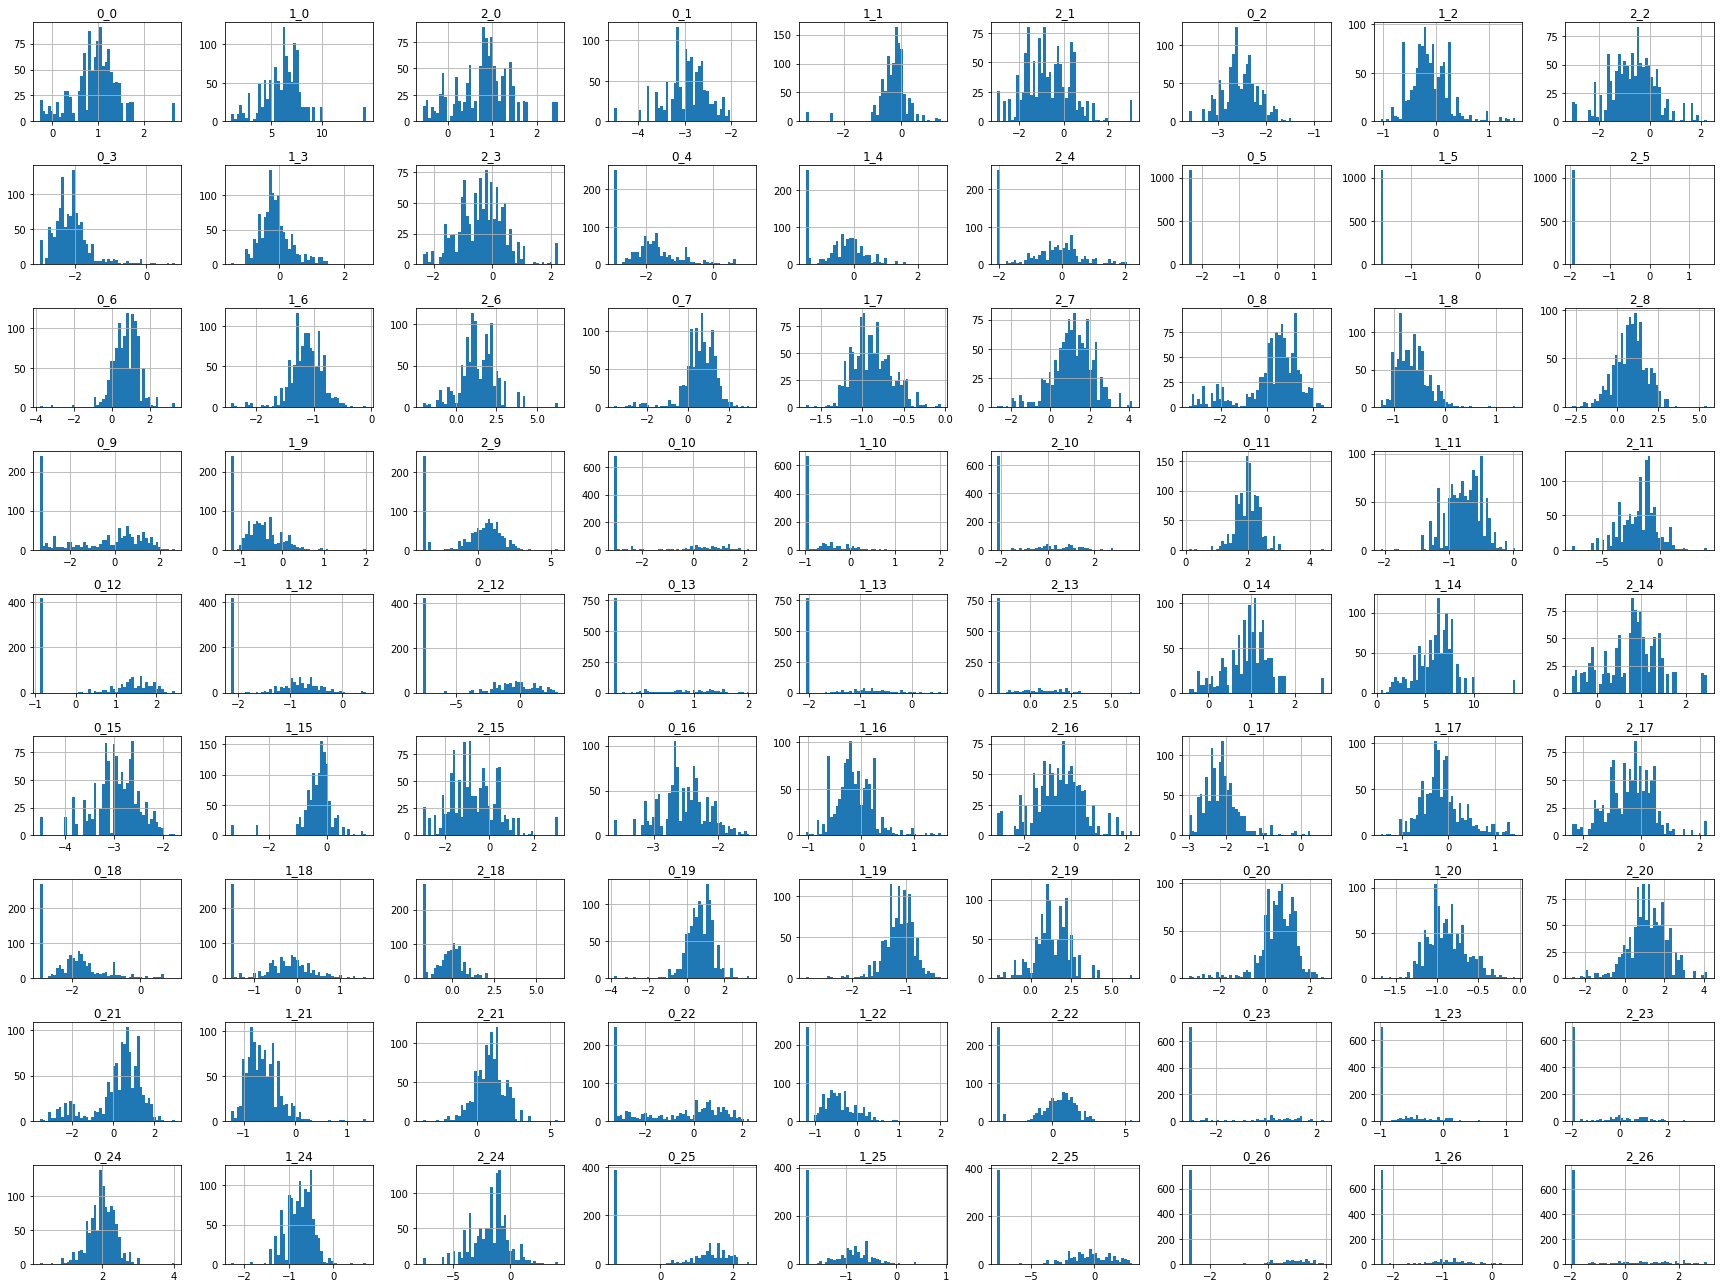

In [17]:
import matplotlib.pyplot as plt 

# Histogram of numerical variables
full.iloc[:, 1:].hist(bins=50, figsize=(24, 18))
plt.tight_layout()

In [71]:
X = full.iloc[:,1:]
y = full.iloc[:, 0]

In [72]:
# standardise
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

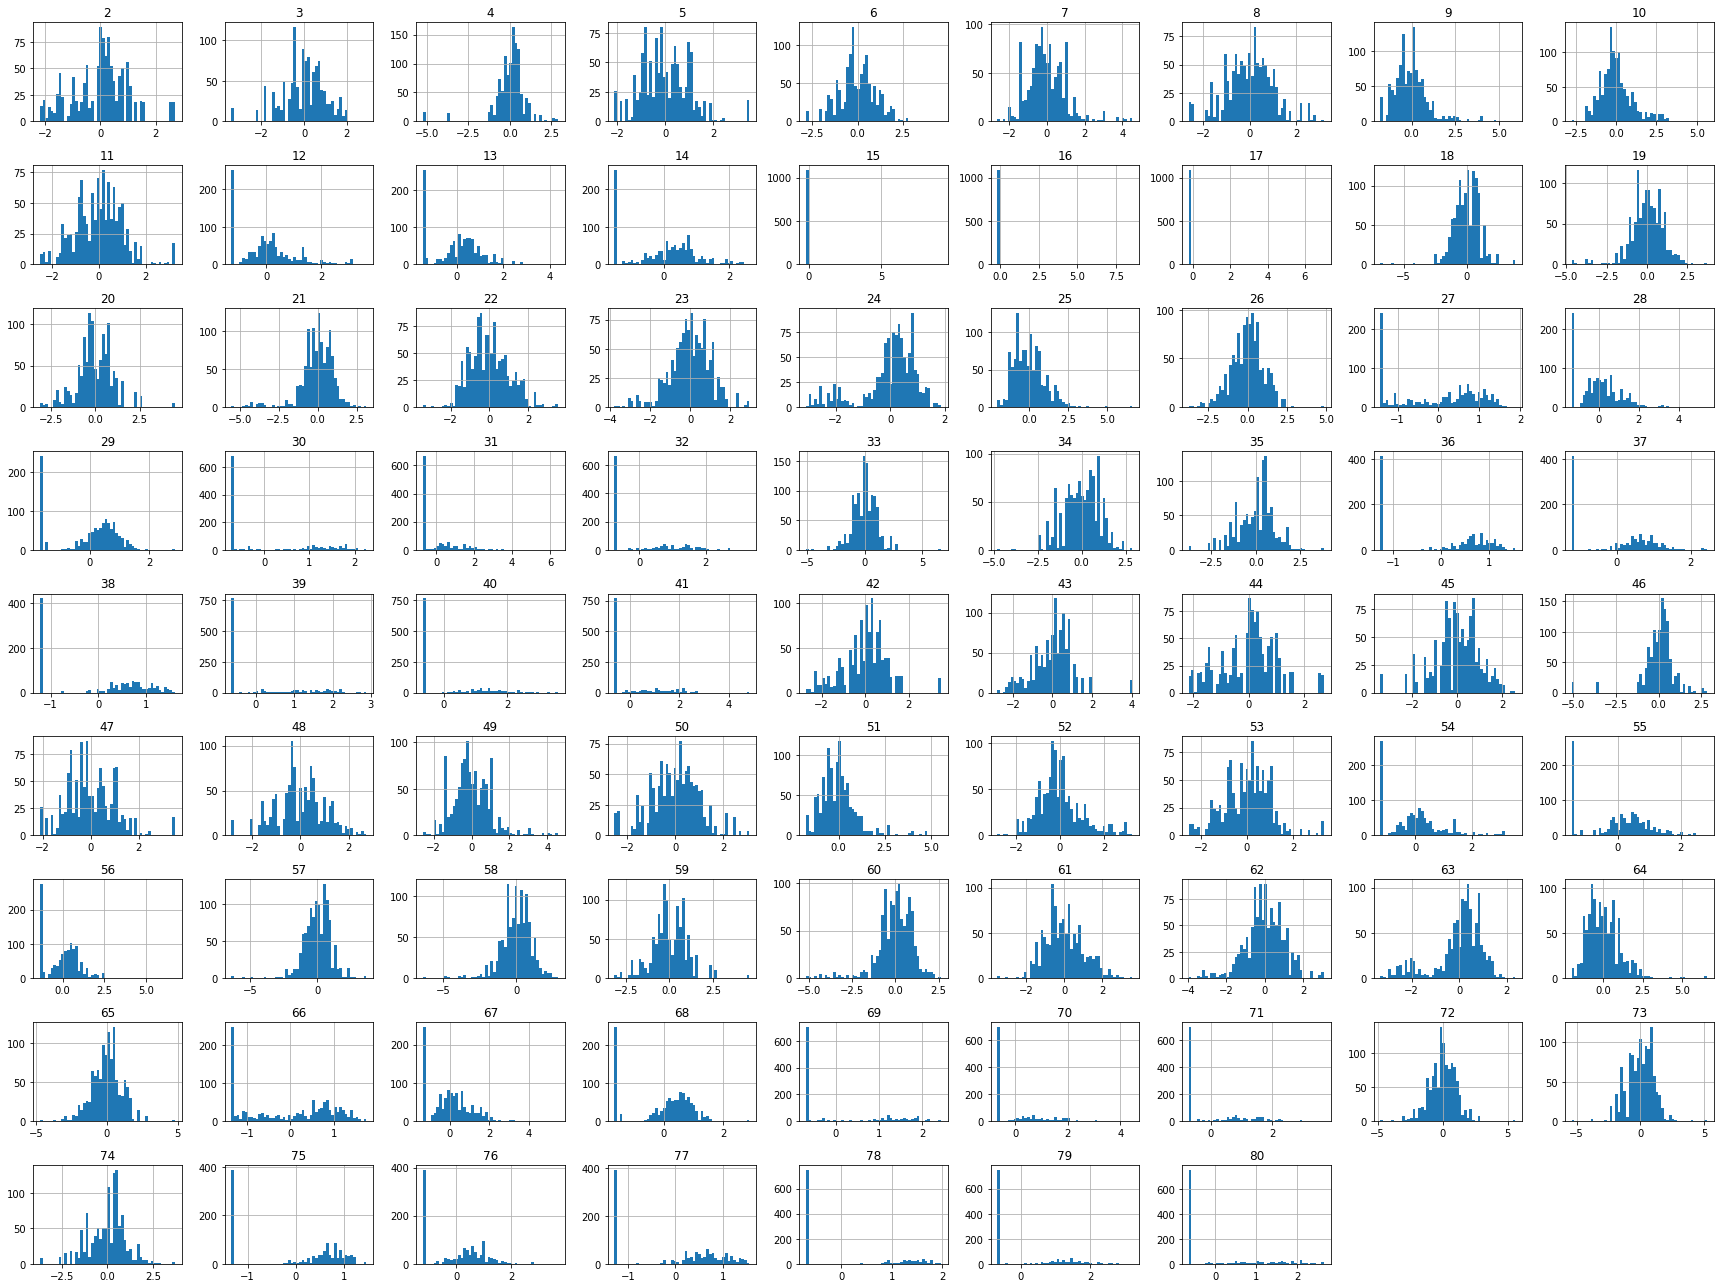

In [52]:
pd.DataFrame(X).iloc[:, 2:].hist(bins=50, figsize=(24, 18))
plt.tight_layout()

### Splitting the dataset into train/dev/test - Stratified sampling

In [73]:
y = y.replace(['lose', 'win', 'draw'], [0, 2, 1])  # convert into int to feed to the models

In [76]:
# stratify by label y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)  # train and test set
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=.5, random_state=42, stratify=y_test)  # train and dev set

# later after experimenting, we will re-train and apply on the official test set

In [77]:
print("Number of training examples: ", X_train.shape[0])
print("Numer of test examples: ", X_test.shape[0])
print("Number of development examples: ", X_dev.shape[0])

Number of training examples:  912
Numer of test examples:  114
Number of development examples:  114


## Training the models

In [78]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    y_pred = clf.predict(features)
    
    return f1_score(target, y_pred, average='weighted'), accuracy_score(target, y_pred)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

In [79]:
clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 42, kernel='rbf')
clf_C = xgb.XGBClassifier(seed = 42)
clf_D = RandomForestClassifier(random_state=42, criterion='entropy')
clf_E = CascadeForestClassifier(random_state=42)


train_predict(clf_A, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_C, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_D, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_E, X_train, y_train, X_test, y_test)

Training a LogisticRegression using a training set size of 912. . .
Trained model in 0.0983 seconds
F1 score and accuracy score for training set: 0.5725 , 0.5855.
F1 score and accuracy score for test set: 0.4069 , 0.4298.

Training a SVC using a training set size of 912. . .
Trained model in 0.1519 seconds
F1 score and accuracy score for training set: 0.7602 , 0.7774.
F1 score and accuracy score for test set: 0.4034 , 0.4649.

Training a XGBClassifier using a training set size of 912. . .
Trained model in 2.0113 seconds
F1 score and accuracy score for training set: 1.0000 , 1.0000.
F1 score and accuracy score for test set: 0.4219 , 0.4474.

Training a RandomForestClassifier using a training set size of 912. . .
Trained model in 1.0381 seconds
F1 score and accuracy score for training set: 1.0000 , 1.0000.
F1 score and accuracy score for test set: 0.4431 , 0.5088.

Training a CascadeForestClassifier using a training set size of 912. . .
[2023-02-05 09:11:49.297] Start to fit the model:
[

### Hyperparameters tuning

In [82]:
# xgboost
parameters = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'max_depth': [1,2,3,4]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(seed=42),
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10,
    verbose=True
)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
{'learning_rate': 0.3, 'max_depth': 1}


In [83]:
train_predict(xgb.XGBClassifier(learning_rate=.3, max_depth=1, seed=42), X_train, y_train, X_test, y_test)

Training a XGBClassifier using a training set size of 912. . .
Trained model in 0.3449 seconds
F1 score and accuracy score for training set: 0.6531 , 0.6732.
F1 score and accuracy score for test set: 0.4433 , 0.4649.


In [47]:
# svc
parameters = {
    'C': [.4, .45, .5, .6, .7, 1.0, 2.0, 3.0]
    # 'kernel': ['rbf', 'linear', 'poly', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10,
    verbose=True
)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
{'C': 0.6}


In [ ]:
# random forest
parameters = {
    'n_estimators': [10, 15, 20, 25, 30],
    'max_depth': [1, 2, 3, 4, 5, 6]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10,
    verbose=True
)

grid_search.fit(X, y)
print(grid_search.best_params_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'max_depth': 6, 'n_estimators': 30}


In [141]:
## deepforest

parameters = {
    'n_estimators': [1, 3, 5],
    # 'n_trees': [1, 3, 5],
    # 'max_layers': [1, 3, 5]
}


grid_search = GridSearchCV(
    estimator=CascadeForestClassifier(),
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10,
    verbose=True
)

grid_search.fit(X, y)
print(grid_search.best_params_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


exception calling callback for <Future at 0x7f794d8bef10 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/lggvu/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/Users/lggvu/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute '_FuncWrapper' on <module 'sklearn.utils.fixes' from '/Users/lggvu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py'>
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/lggvu/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
  File "/Users/lggvu/opt/anaconda3/lib/python3.9/site-packages/joblib/

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

### Results on the test set

## Error analysis